# Decide on cell clusters to exclude

## Import statements

In [1]:
import os,sys
import datetime

In [2]:
import scanpy as sc
sc.logging.print_versions()
sc.logging.print_memory_usage()
sc.settings.verbosity = 2

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.7 numpy==1.15.4 scipy==1.3.1 pandas==0.23.4 scikit-learn==0.20.1 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1
Memory usage: current 0.20 GB, difference +0.20 GB


In [3]:
## This cell is run once to download my custom functions and import statements from github
#
#!git clone --depth=1 https://github.com/rapolaszilionis/utility_functions
#    
## github doesn't seem to have an option to download a specific version of the repo from the history.
## So I download my utility functions and save the download time by appending it to the directory name.
## These utility functions to be shared together with the notebook.
#
#toappend = datetime.datetime.now().strftime('%y%m%d_%Hh%M')
#newname = "utility_functions_%s"%toappend
#print(newname)
#
#
## rename the py file with utility functions
#os.rename("utility_functions",newname)

In [4]:
# add the utility function folder to PATH
sys.path.append(os.path.abspath("utility_functions_200517_09h14/"))

from rz_import_statements import *
import rz_functions as rz
import rz_fig_params # this adjust mpl.rcParams, almost nothing to import, import after scanpy to overwrite rc.Params
import rz_utility_spring as srz

python version: 3.6.7


## Load per-cell metadata (obs)

In [5]:
obs = rz.load_df('backups/obs_info_27563x15_200524_12h47.npz')

## Load cluster labels directly from spring

In [6]:
path1 = "/Users/rapolaszilionis/Google Drive/analyses/SPRING_dev/data/pittet"
project_dir = path1+'/CSF1Ri/'
plot_name = 'all_cells_w_dblt_1000umi'

# use only cell in the spring plot
cell_ix = np.loadtxt(project_dir+plot_name+'/cell_filter.txt',dtype=int)

In [7]:
# load current color dictionary
cg0 = srz.read_cell_groupings(project_dir+plot_name+'/categorical_coloring_data.json')

# drop the color dictionaries with are part of cell groupings
cg0 = {key:value['label_list'] for key,value in cg0.items()}

## Make a dataframe with per-cell metadata with cluster and doublet info

In [8]:
# take doublet info from obs:
o = obs.iloc[cell_ix][['top10pct_dbtl_score','doublet_score']].astype(float).copy()
print(o.shape)

(26009, 2)


In [9]:
# choose cluster configuration
# I chose here a detailed one (overclustered)

label = 'sp_cl_all_cells_w_dblt_1000umi_200'

o[label] = cg0[label]

o.head(3)

,top10pct_dbtl_score,doublet_score,sp_cl_all_cells_w_dblt_1000umi_200
0,0.0,0.151978,147
1,0.0,0.095284,20
2,1.0,0.298507,154


In [10]:
gb = o.groupby(label)
smr = gb.aggregate({'top10pct_dbtl_score':['count','sum'],
             'doublet_score':['mean']})

smr.columns = smr.columns.droplevel()
smr['dblt_fraction'] = smr['sum']/smr['count']

renamer = {'sum':'nr_cell_in_top10_pct_dblt','mean':'mean_dbt_score'}
smr.columns = [renamer[i] if i in renamer else i for i in smr.columns]

smr.head()

,count,nr_cell_in_top10_pct_dblt,mean_dbt_score,dblt_fraction
sp_cl_all_cells_w_dblt_1000umi_200,,,,
0,446,15.0,0.102222,0.033632
1,74,1.0,0.069290,0.013514
10,48,0.0,0.069828,0.000000
100,41,4.0,0.110347,0.097561
101,73,1.0,0.083770,0.013699


## Plot mean dblt score vs fraction potential dblt

/Users/rapolaszilionis/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


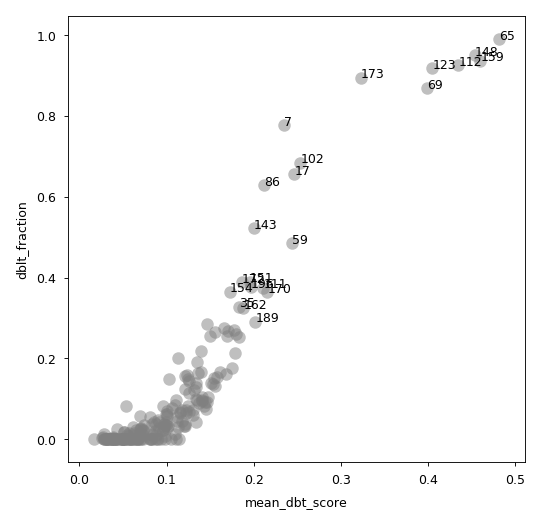

In [11]:
a,fig,gs = rz.startfig(10,10)

lab1 = 'mean_dbt_score'
lab2 = 'dblt_fraction'

x = smr[lab1]
y = smr[lab2]

a.set_xlabel(lab1)
a.set_ylabel(lab2)

# print labels for the top n clusters with highest average dblt score
# and top n with highest fraction
upto=20

thetop = list(x.sort_values(ascending=False)[:upto].index)+\
         list(y.sort_values(ascending=False)[:upto].index)

for i,j,txt in zip(x,y,x.index):
    if txt in thetop:
        a.text(i,j,txt)

a.scatter(x,y,lw=0,c='0.5',alpha=0.5)

## Inspect interactively  
In the interactive SPRING explorer (in browser), inspect whether clusters with high scores. convincingly look like doublets

This includes taking into consideration:
- large clusters are not expected to be doublets
- is there unique gene expression in these clusters? Then they are not doublets.
- can you tell from which real populations these clusters where made?

In [19]:
doubcl = ['65',
          '148',
          '159',
          '112',
          '123',
          '69',
          '173',
          '7',
          
          #102 are basophils, leave.
          
          #Hard to tell regarding 17. These classify as Mono3 (neutrophil-like monocytes)
          #And connect Mono2s to neutrophils is Veh condition. I chose to leave this cluster
          #but keep in mind that Mono3s in general are hard to tell apart from doublets.

          '86', # B and T cell mix
          # 143 and 59 are Mono3s
          
          
         ] #200 config



In [13]:
# add the cluster configuration used to obs
obs[label] = np.nan
obs.loc[obs.index[cell_ix],[label]] = cg0[label]

In [14]:
# append a colotrack saying "removed_as_doublet"
obs['removed_as_dblt'] = obs[label].isin(doubcl)
print(obs['removed_as_dblt'].unique())
obs.head(2)

[False  True]


,barcode,library,total_counts,pct_counts_mito,_library_before_renaming,mouse,condition,closest_Immgen,closest_Zilionis2019_mouse_minor,closest_Immgen_simplified,doublet_score,potential_doublet,top3pct_dbtl_score,top5pct_dbtl_score,top10pct_dbtl_score,sp_cl_all_cells_w_dblt_1000umi_200,removed_as_dblt
0,bcECPI,CSF1Ri_1_1,14875,5.81513,Blz1a,CSF1Ri_1,CSF1Ri,B1a_Sp,mB cells,B1a,0.151978,False,False,False,False,147,False
1,bcESAZ,CSF1Ri_1_1,6876,4.21757,Blz1a,CSF1Ri_1,CSF1Ri,NK_DAP10-_Sp,mT3,NK,0.0952839,False,False,False,False,20,False


## More cluster to remove   
Interactive exploration revealed an RBC-like cluster and a Krt8-high cluster.  

In [15]:
# I need to load data to show expression...
adata = sc.read_h5ad('backups/mito_total_counts_filt_raw_27563x40930_200517_10h29.h5ad')
adata.obs = obs

# normalize
sc.pp.normalize_per_cell(adata,counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [16]:
# there is a cluster of Krt8-hi cells. Also another one of hemoglobing-high cells
genes = ['Krt8','Krt7',
         'Hba-a2','Hba-a1',
         'Hspa1a','Hspa1b', # There is also a tiny neutrophil cluster with a heat-shock-high signature, I leave it
                            # could it be these: https://www.ncbi.nlm.nih.gov/pubmed/15528371 ?
         'Ptprc']

# get centroids:
centroids = rz.centroids(label,adata[cell_ix,:][:,np.in1d(adata.var_names,genes)])

/Users/rapolaszilionis/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


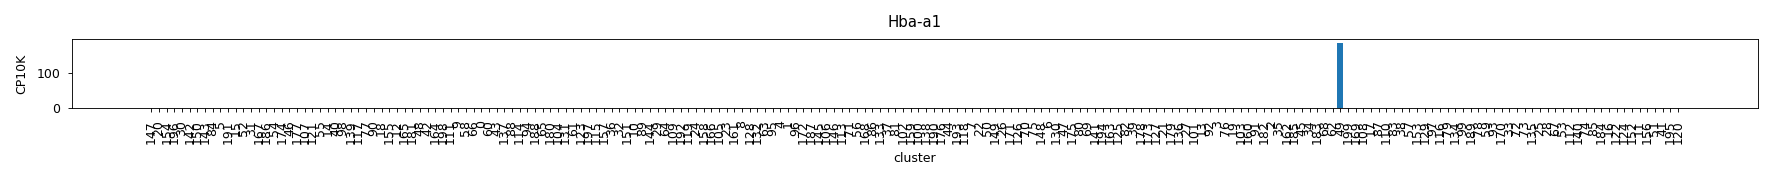

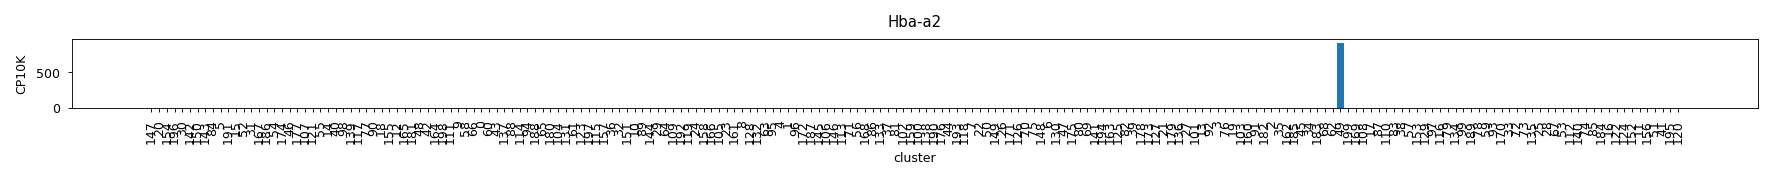

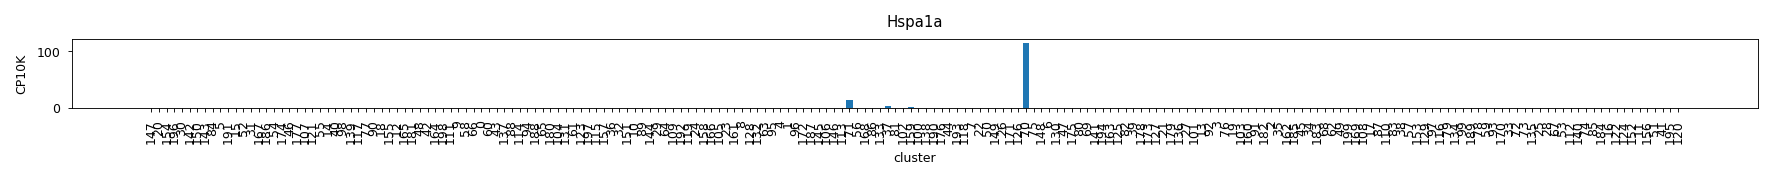

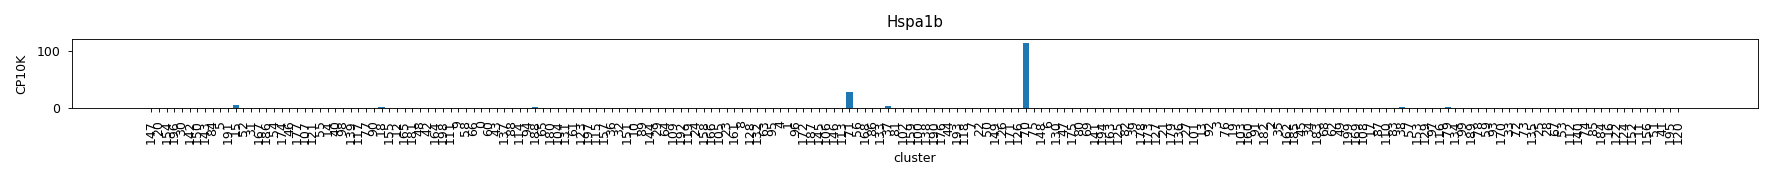

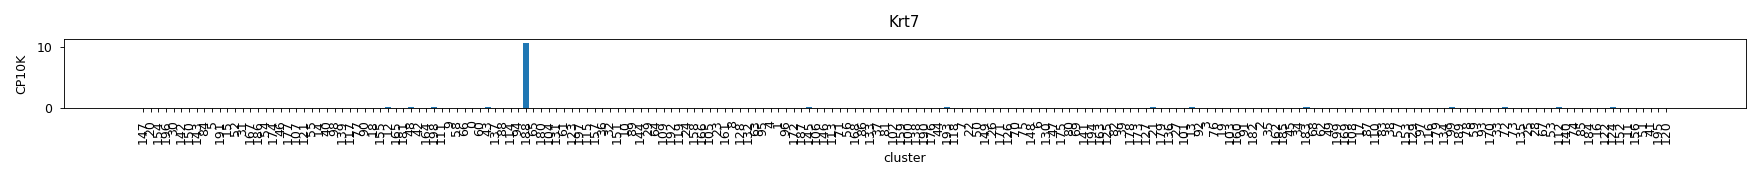

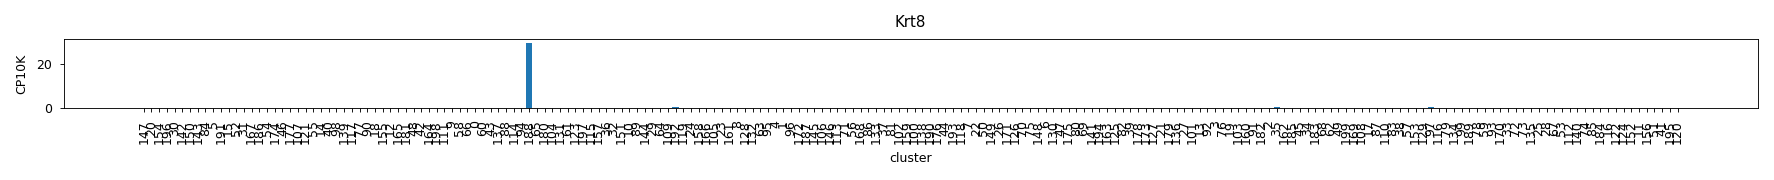

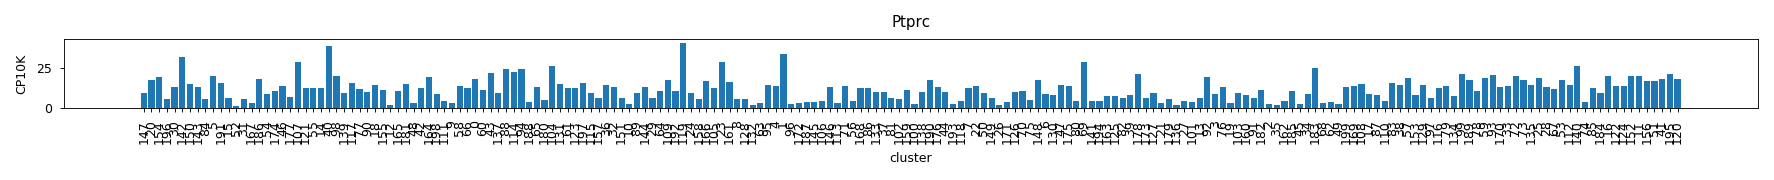

In [17]:
for gene in centroids.columns:
    a,fig,gs=rz.startfig(30,3)
    
    h = centroids[gene]
    x = np.arange(len(h))
    
    a.bar(x,h)
    
    a.set_xticks(x)
    a.set_xticklabels(h.index,rotation=90)
    
    #a.set_yscale('log')
    
    a.set_xlabel('cluster')
    a.set_ylabel('CP10K')
    
    a.set_title(gene)
    gs.tight_layout(fig)
    
    plt.show()

In [18]:
obs['removed_as_RBC'] = obs[label].isin(['49'])
obs['removed_as_Krt8hi'] = obs[label].isin(['188'])

for i in [i for i in obs.columns if i.startswith('removed_as')]:
    print(i,sum(obs[i]))

removed_as_dblt 833
removed_as_RBC 12
removed_as_Krt8hi 24


## Add colotrack to spring

In [20]:
# load current color dictionary
cg_ = srz.read_cell_groupings(project_dir+plot_name+'/categorical_coloring_data.json')

# color dictionary of dictionaries
cdd = {key:value['label_colors'] for key,value in cg_.items()}

cg = obs[[i for i in obs.columns if i.startswith('removed_as')]].iloc[cell_ix].astype(str).to_dict(orient='list')

# append categorical colortrack
srz.append_cell_groupings(project_dir+plot_name,cg,colordd=cdd)

## Save obs

In [21]:
obs.shape

(27563, 20)

In [22]:
# save the update obs dataframe
# no need to save the entire adata object, counts didn't change

fname = 'backups/obs_info_%dx%d_%s'%(obs.shape[0],obs.shape[1],rz.now())
print(fname)
rz.save_df(obs,fname)

backups/obs_info_27563x20_200524_21h32


In [23]:
obs.head()

,barcode,library,total_counts,pct_counts_mito,_library_before_renaming,mouse,condition,closest_Immgen,closest_Zilionis2019_mouse_minor,closest_Immgen_simplified,doublet_score,potential_doublet,top3pct_dbtl_score,top5pct_dbtl_score,top10pct_dbtl_score,sp_cl_all_cells_w_dblt_1000umi_200,removed_as_dblt,n_counts,removed_as_RBC,removed_as_Krt8hi
0,bcECPI,CSF1Ri_1_1,14875,5.81513,Blz1a,CSF1Ri_1,CSF1Ri,B1a_Sp,mB cells,B1a,0.151978,False,False,False,False,147,False,14875.0,False,False
1,bcESAZ,CSF1Ri_1_1,6876,4.21757,Blz1a,CSF1Ri_1,CSF1Ri,NK_DAP10-_Sp,mT3,NK,0.0952839,False,False,False,False,20,False,6876.0,False,False
2,bcIBUV,CSF1Ri_1_1,4643,2.86453,Blz1a,CSF1Ri_1,CSF1Ri,GN_Arth_SynF,mN4,GN,0.298507,False,True,True,True,154,False,4643.0,False,False
3,bcGWNX,CSF1Ri_1_1,5972,6.39652,Blz1a,CSF1Ri_1,CSF1Ri,Mo_6C+II-_LN,mMac1,Mo,0.298507,False,True,True,True,196,False,5972.0,False,False
4,bcCOWJ,CSF1Ri_1_1,5021,3.82394,Blz1a,CSF1Ri_1,CSF1Ri,Mo_6C+II-_LN,mMono1,Mo,0.0424448,False,False,False,False,30,False,5021.0,False,False
